In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
from plot_config import *
from utils import *

In [3]:
# rerun = True

In [4]:
# ds = open_domain_all()

# plt.imshow(ds.A[::100,::100])

# plt.pcolormesh(ds.sf[::100,::100])

# plt.imshow(ds.F[::100,::100]/1e6)
# plt.colorbar()

In [5]:
if rerun:
    ds = open_domain_all()
    
    NUMBER_OF_PARTICLE = NUMBER_OF_PARTICLE_domain_all
    
    for a_region in region_names:
        ds[a_region] = xr.zeros_like(ds['A'])
        for var in ds.data_vars:
            if a_region in var and a_region!=var:
                ds[a_region]+=ds[var]
                print(var, end = ' ')
        print()
    ds['sum'] = xr.zeros_like(ds['A'])
    for var in rhs_list:
        ds['sum']+=ds[var]
        print(var, end = ' ')
    
    ds
    
    bins = 50
    n = len(ds.time)
    m = 1825#len(ds.space)
    size = (n//bins+1, m//bins+1)
    dics = {}
    for var in rhs_list+['sl','sf']+region_names+['sum']:
        dics[var] = np.zeros(size)
    
    j = 0
    for start in range(0,n,bins):
        print(start, end =' ')
    
        xp = 0
        yp = start
        
        # dic = {}
        # for var in rhs_list+['sl','sf']:
        #     dic[var] = []
        i = 0
        while xp<=m and yp-bins>=0:
            
            sl = float(ds.sl[yp,xp])
            # print(xp, end = ' ')
            offset = np.minimum(m-xp,bins)
            sf = float(ds.sf[yp-offset+1,xp+offset-1])
            xslicer = xr.DataArray(np.arange(xp,xp+offset), dims = 'hold')
            yslicer = xr.DataArray(np.arange(yp,yp-offset,-1), dims = 'hold')
            
            dics['sl'][j,i] = sl
            dics['sf'][j,i] = sf
            for var in rhs_list+region_names+['sum']:
                cumsum = float(ds[var][yslicer,xslicer].sum())/NUMBER_OF_PARTICLE
                dics[var][j,i] = cumsum
            xp+=bins
            yp-=bins
            i+=1
        # for var in rhs_list+['sl','sf']:
        #     dic[var] = np.array(dic[var])
        # dics.append(dic)
        j+=1
    
    # %%time
    covs = {}
    for var in rhs_list+region_names+['sf','sl']:
        covs[var] = np.zeros(size[1])
    for col in range(size[1]):
        print(col, end = ' ')
        var_contr = {}
        sl = dics['sl'][size[1]+1:,0]
        var_contr['sf'] = dics['sf'][size[1]+1:,col]
        length = len(sl)
        covs['sl'][col] = np.sum(sl*sl)/length
        for var in rhs_list+region_names:
            var_contr[var] = np.sum(dics[var][size[1]+1:,:col+1],axis = 1)
        for var in rhs_list+region_names+['sf']:
            dotpro = np.sum(var_contr[var]*sl)
            covs[var][col] = dotpro/length
    
    to_output = xr.Dataset()
    length = len(covs['A'])
    for var in covs.keys():
        to_output[var] = xr.DataArray(covs[var],dims = 'dummy')
    to_output.to_zarr('lineplotprep/covdata_domain_all')

In [6]:
the_covs = xr.open_zarr('lineplotprep/covdata_domain_all')
covs = {}
for var in the_covs.data_vars:
    covs[var]= np.array(the_covs[var])

In [7]:
bins = 50
n = 9497
m = 1825#len(ds.space)
size = (n//bins+1, m//bins+1)

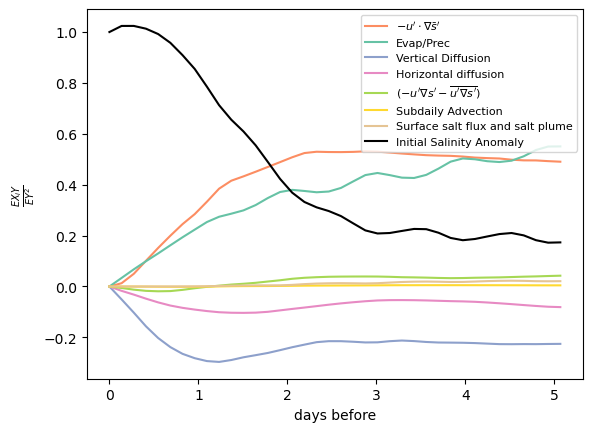

In [8]:
xs = np.arange(0,size[1]*50+1,50)/365
for var in rhs_list+['sf']:
    if var == 'sf':
        plt.plot(xs,[1]+list(covs[var]/covs['sl']),label = 'Initial Salinity Anomaly',color = 'k')
    else:
        plt.plot(xs,[0]+list(-covs[var]/covs['sl']),label = term_dic[var],color = color_dic[var])
plt.xlabel('Years Before')
plt.ylabel(r'$\frac{EX_iY}{EY^2}$')
plt.legend(fontsize = 8)
plt.savefig('figure10(c).png')

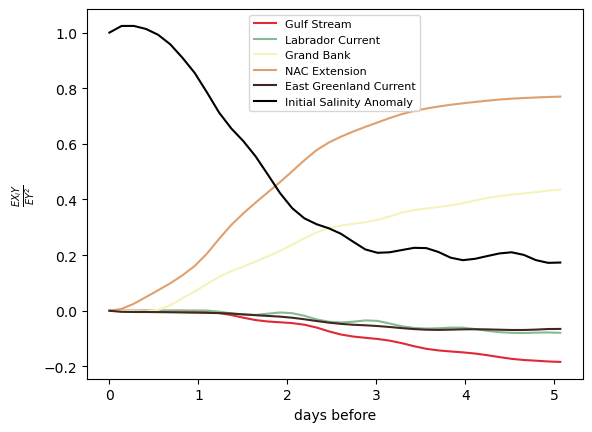

In [9]:
for var in region_names+['sf']:
    if var == 'sf':
        # pass
        plt.plot(xs,[1]+list(covs[var]/covs['sl']),label = 'Initial Salinity Anomaly',color = 'k')
    else:
        plt.plot(xs,[0]+list(-covs[var]/covs['sl']),label = region_longnames[var],color = region_colors[var])
plt.xlabel('Years Before')
plt.ylabel(r'$\frac{EX_iY}{EY^2}$')
plt.legend(fontsize = 8)
plt.savefig('figure10(d).png')